### Importing libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

In [3]:
df = pd.read_csv("diabetes.csv")

### Data Understanding

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Quantiles #####################")
    print(dataframe.describe().T)

In [5]:
check_df(df, head=5)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627

<AxesSubplot:>

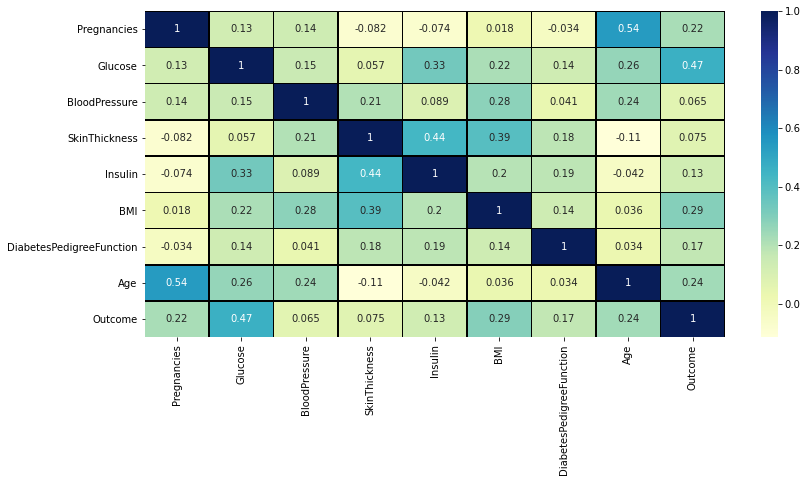

In [6]:
corr = df.corr() 
plt.figure(figsize=(13,6))
sns.heatmap(corr,annot=True,linecolor="black",cmap='YlGnBu',lw=0.5) 

In [7]:
df.columns = [col.upper() for col in df.columns]

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


### Target Visualization

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='OUTCOME', ylabel='count'>

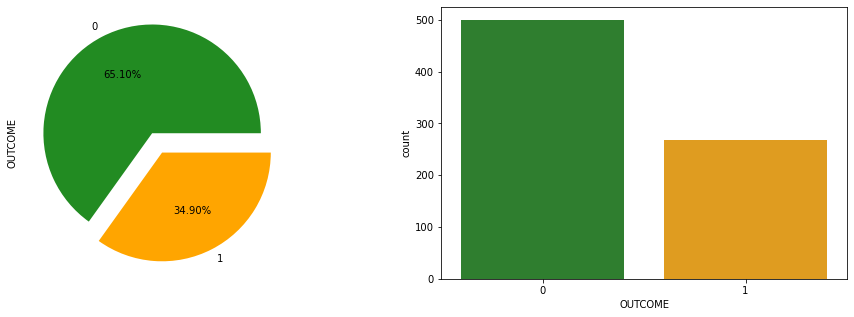

In [9]:
fig,ax=plt.subplots(ncols=2,figsize=(16,5)) 
df["OUTCOME"].value_counts().plot.pie(autopct="%.2f%%",colors=['forestgreen','orange'],explode = (0.1, 0.1),ax=ax[0])
sns.countplot(df["OUTCOME"],ax=ax[1],palette=['forestgreen','orange'])

### Missing Value Control

In [10]:
def missing_value_table(df):
    missing_value = df.isna().sum().sort_values(ascending=False)
    missing_value_percent = 100 * df.isna().sum()//len(df)
    missing_value_table = pd.concat([missing_value, missing_value_percent], axis=1)
    missing_value_table_return = missing_value_table.rename(columns = {0 : 'Missing Values', 1 : '% Value'})
    cm = sns.light_palette("red", as_cmap=True)
    missing_value_table_return = missing_value_table_return.style.background_gradient(cmap=cm)
    return missing_value_table_return

In [11]:
missing_value_table(df)

,Missing Values,% Value
OUTCOME,0,0
AGE,0,0
DIABETESPEDIGREEFUNCTION,0,0
BMI,0,0
INSULIN,0,0
SKINTHICKNESS,0,0
BLOODPRESSURE,0,0
GLUCOSE,0,0
PREGNANCIES,0,0


In [12]:
#Values cannot be 0. Let's fill those values with nan
missing_cols = [col for col in df.columns if(df[col].min()== 0 and col not in ["OUTCOME","PREGNANCIES"])]

for i in missing_cols:
    df[i] = np.where(df[i] == 0, np.nan, df[i])

In [13]:
missing_value_table(df)

,Missing Values,% Value
INSULIN,374,48
SKINTHICKNESS,227,29
BLOODPRESSURE,35,4
BMI,11,1
GLUCOSE,5,0
OUTCOME,0,0
AGE,0,0
DIABETESPEDIGREEFUNCTION,0,0
PREGNANCIES,0,0


In [14]:
def fill_median(variable):   
    temp = df[df[variable].notnull()]
    temp = temp[[variable, 'OUTCOME']].groupby(['OUTCOME'])[[variable]].median().reset_index()
    return temp

In [15]:
for col in missing_cols:
    df.loc[(df["OUTCOME"]== 0) & (df[col].isnull()),col] = fill_median(col)[col][0]
    df.loc[(df["OUTCOME"]== 1) & (df[col].isnull()),col] = fill_median(col)[col][1]

In [16]:
missing_value_table(df)

,Missing Values,% Value
OUTCOME,0,0
AGE,0,0
DIABETESPEDIGREEFUNCTION,0,0
BMI,0,0
INSULIN,0,0
SKINTHICKNESS,0,0
BLOODPRESSURE,0,0
GLUCOSE,0,0
PREGNANCIES,0,0


### Outlier Data Control

In [17]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [18]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [19]:
for col in num_cols:
    print(col, check_outlier(df, col))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS True
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


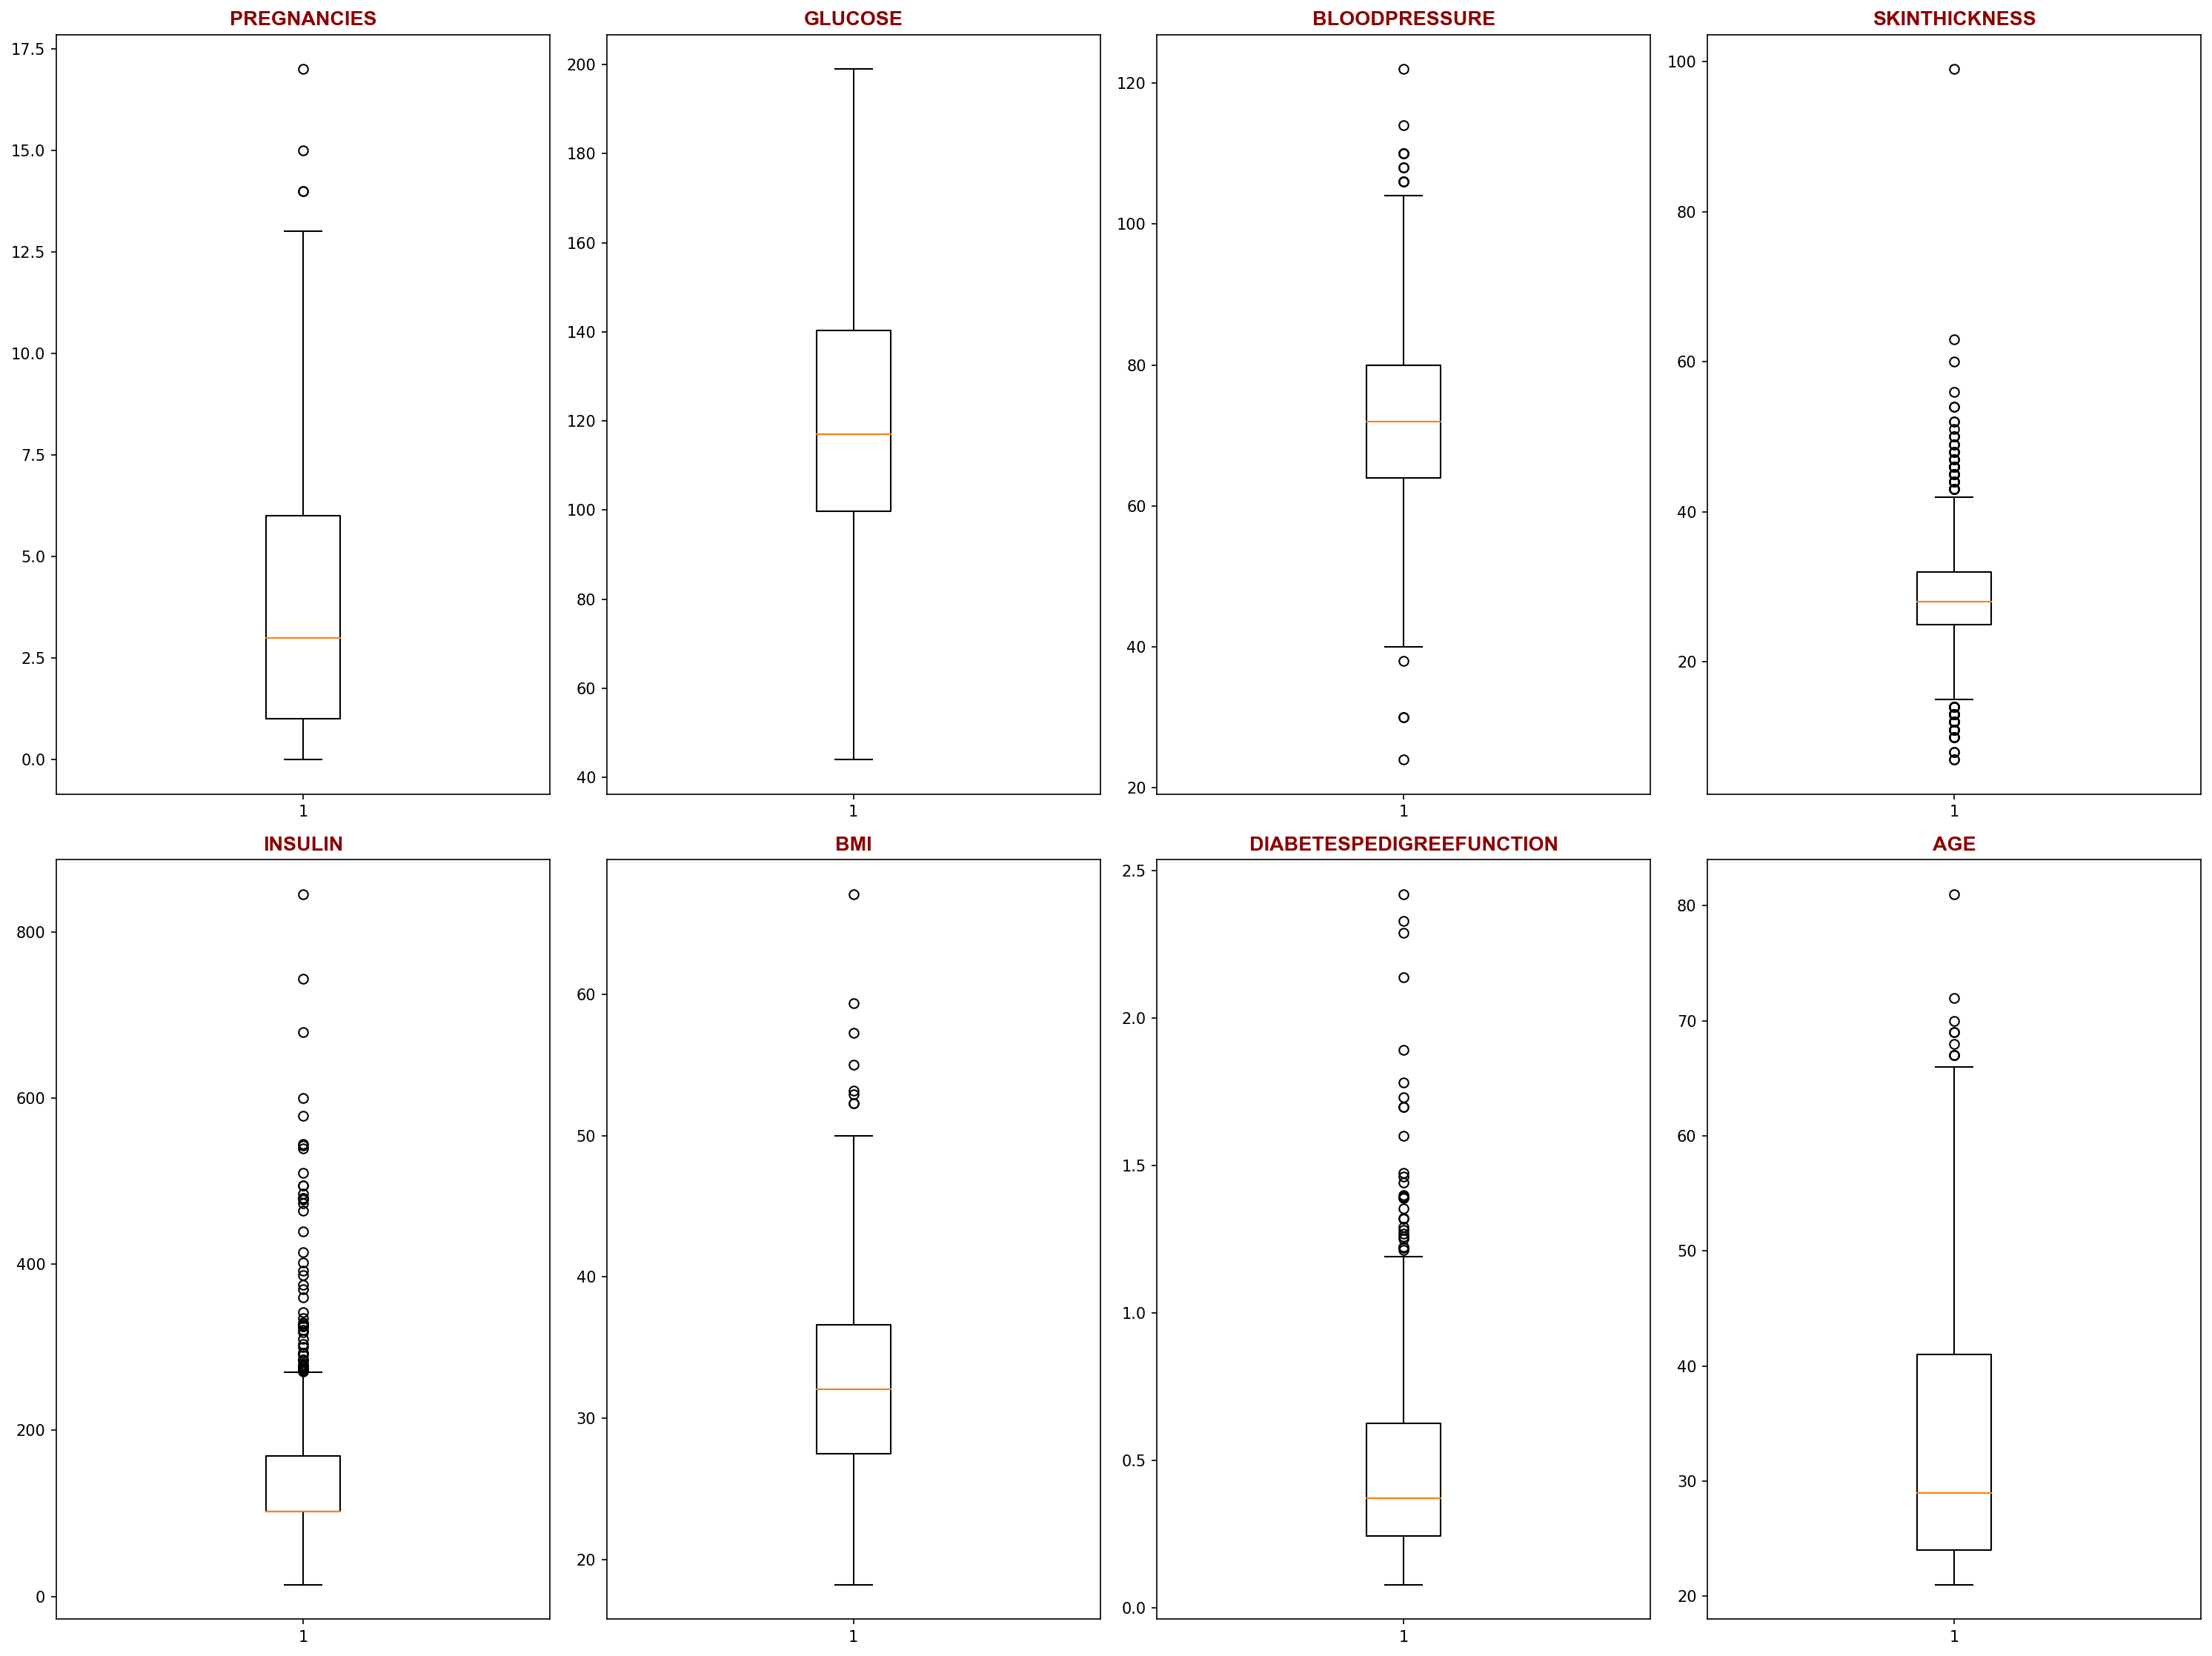

In [20]:
def draw_boxplot(dataframe):
    baslik_font={'family':'arial','color':'darkred','weight':'bold','size':13}
    eksen_font={'family':'arial','color':'darkblue','weight':'bold','size':10}
    plt.figure(figsize=(20,15),dpi=150)
    fill_list=['PREGNANCIES','GLUCOSE','BLOODPRESSURE','SKINTHICKNESS','INSULIN','BMI','DIABETESPEDIGREEFUNCTION','AGE']
    for i,col in enumerate(fill_list):
        plt.subplot(2,4,i+1)
        plt.boxplot(col, data=df)
        plt.title(col,fontdict=baslik_font)
    plt.tight_layout()
    plt.show()
    
draw_boxplot(df)   

In [21]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in num_cols:
    replace_with_thresholds(df, col)    

In [22]:
for col in num_cols:
    print(col, check_outlier(df, col))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN False
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


### Feature Engineering

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: PREGNANCIES, dtype: float64


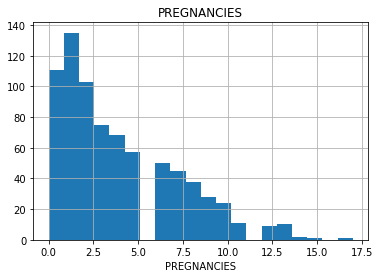

count    768.000000
mean     121.677083
std       30.464161
min       44.000000
5%        80.000000
10%       86.700000
20%       95.000000
30%      102.100000
40%      109.000000
50%      117.000000
60%      125.000000
70%      135.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: GLUCOSE, dtype: float64


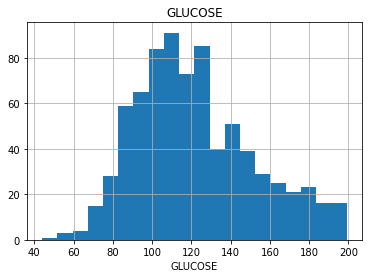

count    768.000000
mean      72.389323
std       12.106039
min       24.000000
5%        52.000000
10%       58.000000
20%       62.000000
30%       66.000000
40%       70.000000
50%       72.000000
60%       74.500000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BLOODPRESSURE, dtype: float64


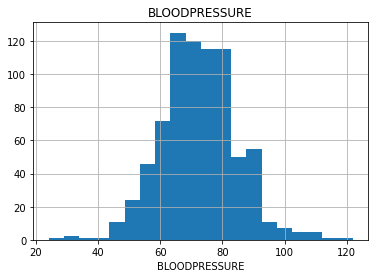

count    768.000000
mean      29.076139
std        8.790464
min        7.000000
5%        14.350000
10%       18.000000
20%       23.000000
30%       27.000000
40%       27.000000
50%       28.000000
60%       31.200000
70%       32.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       88.475000
Name: SKINTHICKNESS, dtype: float64


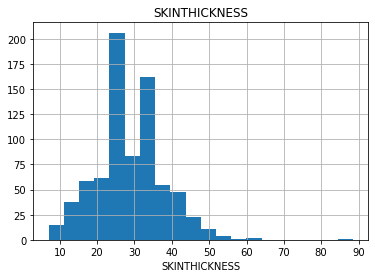

count    768.000000
mean     141.366536
std       86.498435
min       14.000000
5%        50.000000
10%       67.000000
20%      102.500000
30%      102.500000
40%      102.500000
50%      102.500000
60%      140.000000
70%      169.500000
80%      169.500000
90%      210.000000
95%      293.000000
99%      519.900000
max      657.500000
Name: INSULIN, dtype: float64


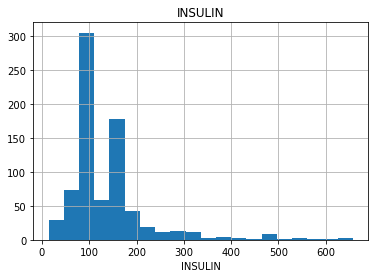

count    768.000000
mean      32.434635
std        6.880498
min       18.200000
5%        22.235000
10%       24.000000
20%       26.200000
30%       28.500000
40%       30.100000
50%       32.050000
60%       33.720000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


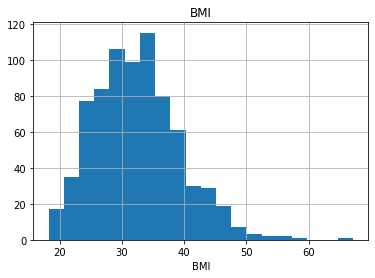

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DIABETESPEDIGREEFUNCTION, dtype: float64


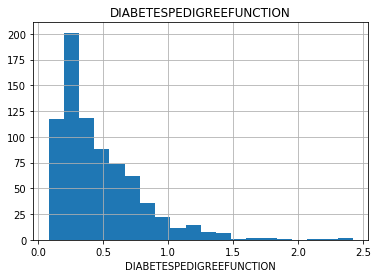

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: AGE, dtype: float64


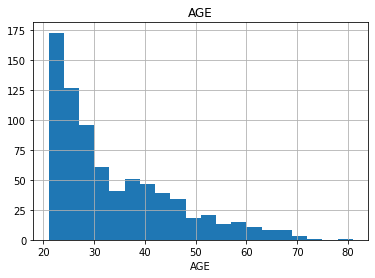

In [23]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()
        

for col in num_cols:
    num_summary(df, col, plot=True)        

In [24]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
    
for col in num_cols:
    target_summary_with_num(df, "OUTCOME", col)

         PREGNANCIES
OUTCOME             
0           3.298000
1           4.865672


            GLUCOSE
OUTCOME            
0        110.622000
1        142.302239


         BLOODPRESSURE
OUTCOME               
0            70.844000
1            75.272388


         SKINTHICKNESS
OUTCOME               
0            27.170000
1            32.632369


            INSULIN
OUTCOME            
0        116.954000
1        186.912313


               BMI
OUTCOME           
0        30.846000
1        35.398507


         DIABETESPEDIGREEFUNCTION
OUTCOME                          
0                        0.429734
1                        0.550500


               AGE
OUTCOME           
0        31.190000
1        37.067164




In [25]:
bins = [20, 30, 41, 52, 63, int(df["AGE"].max())]
mylabels = ['20_30', '31_41', '42_52', '53_63', '64_' + str(int(df["AGE"].max()))]

# age'i bölelim:
df["AGE_CAT"] = pd.cut(df["AGE"], bins, labels=mylabels)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,AGE_CAT
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,42_52
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0,31_41
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,31_41
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,20_30
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1,31_41


In [26]:
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'

In [27]:
df.loc[(df['GLUCOSE'] >= 70) & (df['GLUCOSE'] <= 100), 'CAT_GLUCOSE'] = 'normal'
df.loc[(df['GLUCOSE'] >= 100) & (df['GLUCOSE'] <= 125), 'CAT_GLUCOSE'] = 'hidden sugar'
df.loc[df['GLUCOSE'] >= 126, 'CAT_GLUCOSE'] = 'diabetes'

In [28]:
df.loc[(df['BMI'] >= 0) & (df['BMI'] < 18.5), 'NEW_BMI_CAT'] = 'underweight'
df.loc[(df['BMI'] >= 18.5) & (df['BMI'] < 25), 'NEW_BMI_CAT'] = 'normal'
df.loc[(df['BMI'] >= 25) & (df['BMI'] < 30), 'NEW_BMI_CAT'] = 'overweight'
df.loc[(df['BMI'] >= 30) & (df['BMI'] < 35), 'NEW_BMI_CAT'] = 'first degree obese'
df.loc[(df['BMI'] >= 35) & (df['BMI'] < 45), 'NEW_BMI_CAT'] = 'second degree obese'
df.loc[df['BMI'] >= 45, 'NEW_BMI_CAT'] = 'third degree obese'

In [29]:
df.loc[(df['INSULIN'] >= 0) & (df['INSULIN'] <= 70), 'NEW_INSULIN_CAT'] = 'low'
df.loc[(df['INSULIN'] > 70) & (df['INSULIN'] <= 100), 'NEW_INSULIN_CAT'] = 'normal'
df.loc[(df['INSULIN'] > 100)& (df['INSULIN'] <= 200),'NEW_INSULIN_CAT'] = 'risk'
df.loc[(df['INSULIN'] >= 200), 'NEW_INSULIN_CAT'] = 'diabetes'

In [30]:
bins = [0,80, 90, 120, 122]

mylabels = ['0_80', '80_90', '90_120', '120_122']

df["BLOODPRESSURE_CAT"] = pd.cut(df["BLOODPRESSURE"], bins, labels=mylabels)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,AGE_CAT,NEW_AGE_CAT,CAT_GLUCOSE,NEW_BMI_CAT,NEW_INSULIN_CAT,BLOODPRESSURE_CAT
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,42_52,mature,diabetes,first degree obese,risk,0_80
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0,31_41,mature,normal,overweight,risk,0_80
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,31_41,mature,diabetes,normal,risk,0_80
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,20_30,mature,normal,overweight,normal,0_80
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1,31_41,mature,diabetes,second degree obese,risk,0_80


In [31]:
df.loc[(df["PREGNANCIES"] == 0), "IS_PREGNANT"] = 0
df.loc[(df["PREGNANCIES"] >= 1), "IS_PREGNANT"] = 1

In [32]:
df['GESTATIONAL_RISK'] = ((df['AGE'] > 30) & (df['BMI'] > 30) & (df['PREGNANCIES'] != 0)).astype('int')

In [33]:
df["PREGNANCIES/AGE_RATIO"]=df["PREGNANCIES"]/df["AGE"]

In [34]:
df

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,AGE_CAT,NEW_AGE_CAT,CAT_GLUCOSE,NEW_BMI_CAT,NEW_INSULIN_CAT,BLOODPRESSURE_CAT,IS_PREGNANT,GESTATIONAL_RISK,PREGNANCIES/AGE_RATIO
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,42_52,mature,diabetes,first degree obese,risk,0_80,1.0,1,0.120000
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0,31_41,mature,normal,overweight,risk,0_80,1.0,0,0.032258
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,31_41,mature,diabetes,normal,risk,0_80,1.0,0,0.250000
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,20_30,mature,normal,overweight,normal,0_80,1.0,0,0.047619
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1,31_41,mature,diabetes,second degree obese,risk,0_80,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0,53_63,senior,hidden sugar,first degree obese,risk,0_80,1.0,1,0.158730
764,2.0,122.0,70.0,27.0,102.5,36.8,0.340,27.0,0,20_30,mature,hidden sugar,second degree obese,risk,0_80,1.0,0,0.074074
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0,20_30,mature,hidden sugar,overweight,risk,0_80,1.0,0,0.166667
766,1.0,126.0,60.0,32.0,169.5,30.1,0.349,47.0,1,42_52,mature,diabetes,first degree obese,risk,0_80,1.0,1,0.021277


### Data Transformation

#### Label Encoding

In [35]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

binary_cols 

['NEW_AGE_CAT']

In [36]:
from sklearn.preprocessing import  LabelEncoder, StandardScaler
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

for col in binary_cols:
    df = label_encoder(df, col)

#### One-Hot Encoding

In [37]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [38]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols)

In [39]:
df

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,...,NEW_BMI_CAT_third degree obese,NEW_BMI_CAT_underweight,NEW_INSULIN_CAT_diabetes,NEW_INSULIN_CAT_low,NEW_INSULIN_CAT_normal,NEW_INSULIN_CAT_risk,BLOODPRESSURE_CAT_0_80,BLOODPRESSURE_CAT_80_90,BLOODPRESSURE_CAT_90_120,BLOODPRESSURE_CAT_120_122
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,0,...,0,0,0,0,0,1,1,0,0,0
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,0,...,0,0,0,0,0,1,1,0,0,0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1,0,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0,1,...,0,0,0,0,0,1,1,0,0,0
764,2.0,122.0,70.0,27.0,102.5,36.8,0.340,27.0,0,0,...,0,0,0,0,0,1,1,0,0,0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0,0,...,0,0,0,0,0,1,1,0,0,0
766,1.0,126.0,60.0,32.0,169.5,30.1,0.349,47.0,1,0,...,0,0,0,0,0,1,1,0,0,0


In [40]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

Observations: 768
Variables: 35
cat_cols: 26
num_cols: 9
cat_but_car: 0
num_but_cat: 26


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,...,NEW_BMI_CAT_third degree obese,NEW_BMI_CAT_underweight,NEW_INSULIN_CAT_diabetes,NEW_INSULIN_CAT_low,NEW_INSULIN_CAT_normal,NEW_INSULIN_CAT_risk,BLOODPRESSURE_CAT_0_80,BLOODPRESSURE_CAT_80_90,BLOODPRESSURE_CAT_90_120,BLOODPRESSURE_CAT_120_122
0,0.639947,0.864625,-0.032180,0.674335,0.325460,0.169483,0.468492,1.425995,1,0,...,0,0,0,0,0,1,1,0,0,0
1,-0.844885,-1.204727,-0.528124,-0.008667,-0.449625,-0.848549,-0.365061,-0.190672,0,0,...,0,0,0,0,0,1,1,0,0,0
2,1.233880,2.014265,-0.693438,0.332834,0.325460,-1.328478,0.604397,-0.105584,1,0,...,0,0,0,0,0,1,1,0,0,0
3,-0.844885,-1.073339,-0.528124,-0.691670,-0.547957,-0.630399,-0.920763,-1.041549,0,0,...,0,0,0,0,1,0,1,0,0,0
4,-1.141852,0.503310,-2.677212,0.674335,0.308108,1.551096,5.484909,-0.020496,1,0,...,0,0,0,0,0,1,1,0,0,0


In [41]:
check_df(df)

##################### Shape #####################
(768, 35)
##################### Types #####################
PREGNANCIES                        float64
GLUCOSE                            float64
BLOODPRESSURE                      float64
SKINTHICKNESS                      float64
INSULIN                            float64
BMI                                float64
DIABETESPEDIGREEFUNCTION           float64
AGE                                float64
OUTCOME                              int64
NEW_AGE_CAT                          int64
IS_PREGNANT                        float64
GESTATIONAL_RISK                     int64
PREGNANCIES/AGE_RATIO              float64
AGE_CAT_20_30                        uint8
AGE_CAT_31_41                        uint8
AGE_CAT_42_52                        uint8
AGE_CAT_53_63                        uint8
AGE_CAT_64_81                        uint8
CAT_GLUCOSE_diabetes                 uint8
CAT_GLUCOSE_hidden sugar             uint8
CAT_GLUCOSE_normal            

### Save Csv

In [42]:
df.to_csv('prep_diabetes.csv') 